In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from getdist import plots, MCSamples

def get_par_info(chain, param, limit):
    s = chain.getInlineLatex(param, limit=limit)
    s = s.split(' = ')[1]
    if '\pm' in s:
        v, e = [float(i) for i in s.split('\pm')]
        p = m = e
    else:
        v = float(s.split('^{')[0])
        p, m = s.split('^{+')[1].split('_{-')
        p = float(p.strip('}'))
        m = float(m.strip('}'))
    return np.array([v, m, p])

Read catalog

In [4]:
c = fits.open("/mnt/extraspace/damonge/Datasets/COSMOS/COSMOS_PAUS_matched.fits")[1].data

Functions to obtain mean Dz and fit a linear model to it

# Fit directly [IN PAPER]

In [33]:
def fit_linear(x, y, s):
    icov = np.diag(1/s**2)
    xmat = np.array([np.ones_like(x), x])
    icov_p = np.dot(xmat, np.dot(icov, xmat.T))
    cov_p = np.linalg.inv(icov_p)
    b, m = np.dot(cov_p, np.dot(xmat, np.dot(icov, y)))
    return b, m, cov_p
    

def get_dz(cat, bins):
    n = np.histogram(cat['photoz'], bins=bins)[0]
    z = np.histogram(cat['photoz'], weights=cat['photoz'], bins=bins)[0]
    dz = np.histogram(cat['photoz'], weights=cat['photoz']-cat['PHOTOZ'], bins=bins)[0]
    dz2 = np.histogram(cat['photoz'], weights=(cat['photoz']-cat['PHOTOZ'])**2, bins=bins)[0]
    z = z/n
    dz = dz/n
    sz = np.sqrt(dz2/n-dz**2)/np.sqrt(n)
    dz0, m, _ = fit_linear(z, dz, np.ones_like(z))
    return n, z, dz, sz, dz0, m



Obtain model parameters from catalog

In [34]:
zbins = [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0]
ns, zms, dzs, szs, _, _ = get_dz(c, zbins)
dz0, m, cov = fit_linear(zms, dzs, szs)
print('Dz = %lf + %lf * z_true' % (dz0, m))

Dz = -0.002543 + 0.017676 * z_true


In [31]:
ns, dzs, szs, szs * np.sqrt(ns)

(array([ 5724,  9478,  8349, 12665,  3708,   591]),
 array([0.00045038, 0.00459131, 0.00825149, 0.01217914, 0.01835356,
        0.0256731 ]),
 array([0.00135257, 0.00069885, 0.0004333 , 0.0003674 , 0.00143269,
        0.00592797]),
 array([0.10233143, 0.06803673, 0.03959206, 0.04134623, 0.08724112,
        0.14411181]))

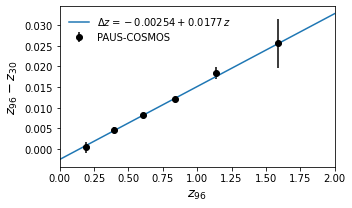

In [5]:
# IN PAPER
f, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
zz = np.linspace(0, 2, 100)
plt.plot(zz, dz0+m*(zz), label=f'$\Delta z = {dz0:.5f} + {m:.4f}\, z$')
plt.xlabel('$z_{96}$', fontsize=13)
plt.ylabel('$z_{96}-z_{30}$', fontsize=13)
plt.xlim([0, 2])
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('/mnt/zfsusers/gravityls_3/codes/DESxHSC/paper_plots/zdiff_PAU.pdf')
plt.show()
plt.close()

Compute bootstrap errors and covariance

In [6]:
ngal = len(c)
dz0s, ms = [], []
for i in range(250):
    if i % 10 == 0:
        print(i)
    ids = np.random.choice(range(ngal), size=ngal)
    _, _, _, _, dz0_h, m_h = get_dz(c[ids], zbins)
    dz0s.append(dz0_h)
    ms.append(m_h)
dz0s = np.array(dz0s)
ms = np.array(ms)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [7]:
cv = np.cov(np.array([dz0s, ms]))
print('sigma(A), sigma(B) = ', np.sqrt(np.diag(cv)))
print('r_mat = ',cv/np.sqrt(np.diag(cv)[:, None]*np.diag(cv)[None, :]))

sigma(A), sigma(B) =  [0.00193317 0.00357137]
r_mat =  [[ 1.         -0.97132836]
 [-0.97132836  1.        ]]


(0.0, 2.0)

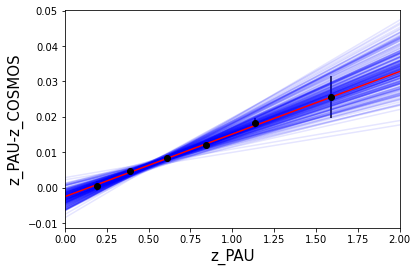

In [8]:
plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
zz = np.linspace(0, 2, 100)
for dz0_h, m_h in zip(dz0s, ms):
    plt.plot(zz, dz0_h+m_h*(zz), 'b-', alpha=0.1)
plt.plot(zz, dz0+m*(zz), 'r-', label='%lf + %lf * z' % (dz0, m))
plt.xlabel('z_PAU', fontsize=15)
plt.ylabel('z_PAU-z_COSMOS', fontsize=15)
plt.xlim([0, 2])

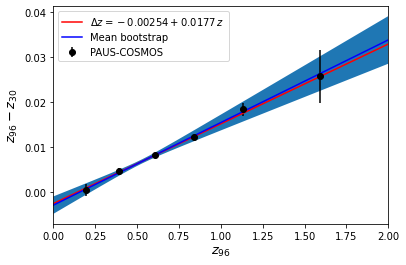

In [9]:
zz = np.linspace(0, 2, 50)
dz = []
sdz = []
mdz = []
for izz in zz: 
    dz.append(dz0s + ms*(izz))
    mdz.append(np.mean(dz[-1]))
    sdz.append(np.std(dz[-1]))
dz = np.array(dz)
sdz = np.array(sdz)
mdz = np.array(mdz)

plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
plt.plot(zz, dz0+m*(zz), 'r-', label=f'$\Delta z = {dz0:.5f} + {m:.4f}\, z$')
# plt.plot(zz, dz0+m*(zz), 'r-', label='Best fit')
plt.plot(zz, mdz, c='b', label='Mean bootstrap')
# plt.errorbar(zz, mdz, yerr=sdz, fmt='.', color='b')
plt.fill_between(zz, mdz-sdz, mdz+sdz)
plt.legend()

plt.xlabel('$z_{96}$', fontsize=13)
plt.ylabel('$z_{96}-z_{30}$', fontsize=13)
plt.xlim([0, 2])

plt.show()

Removed no burn in


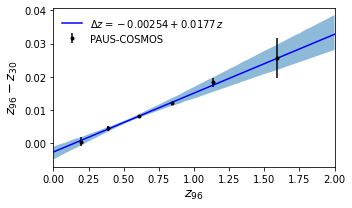

In [11]:
pnames = [f'dz_{izz}' for izz in zz]
samples = MCSamples(samples=dz.T, names=pnames)

pinfo = np.zeros((len(pnames), 3))
for i, pn in enumerate(pnames):
    pinfo[i] = get_par_info(samples, pn, 1)

f, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.errorbar(zms, dzs, yerr=szs, fmt='k.', label='PAUS-COSMOS')
plt.plot(zz, dz0+m*(zz), color='b',  label=f'$\Delta z = {dz0:.5f} + {m:.4f}\, z$')
# plt.plot(zz, pinfo[:, 0], c='b', label='Mean bootstrap')
plt.fill_between(zz, pinfo[:, 0]-pinfo[:, 1], pinfo[:, 0]+pinfo[:, 2], alpha=0.5)

plt.xlabel('$z_{96}$', fontsize=13)
plt.ylabel('$z_{96}-z_{30}$', fontsize=13)
plt.xlim([0, 2])

plt.legend(loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig('/mnt/zfsusers/gravityls_3/codes/DESxHSC/paper_plots/zdiff_PAU.pdf')
plt.show()
plt.close()

In [ ]:
# Numerical coparison with quick mean/std way 
pinfo[:, 0] /  mdz - 1, pinfo[:, 1] /  sdz - 1, pinfo[:, 2] /  sdz - 1

# Fit shifted

In [5]:
def fit_linear(x, y, s):
    icov = np.diag(1/s**2)
    xmat = np.array([np.ones_like(x), x-0.5])
    icov_p = np.dot(xmat, np.dot(icov, xmat.T))
    cov_p = np.linalg.inv(icov_p)
    b, m = np.dot(cov_p, np.dot(xmat, np.dot(icov, y)))
    return b, m, cov_p
    

def get_dz(cat, bins):
    n = np.histogram(cat['photoz'], bins=bins)[0]
    z = np.histogram(cat['photoz'], weights=cat['photoz'], bins=bins)[0]
    dz = np.histogram(cat['photoz'], weights=cat['photoz']-cat['PHOTOZ'], bins=bins)[0]
    dz2 = np.histogram(cat['photoz'], weights=(cat['photoz']-cat['PHOTOZ'])**2, bins=bins)[0]
    z = z/n
    dz = dz/n
    sz = np.sqrt(dz2/n-dz**2)/np.sqrt(n)
    dz0, m, _ = fit_linear(z, dz, np.ones_like(z))
    return n, z, dz, sz, dz0, m



Obtain model parameters from catalog

In [6]:
zbins = [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0]
ns, zms, dzs, szs, _, _ = get_dz(c, zbins)
dz0, m, cov = fit_linear(zms, dzs, szs)
print('Dz = %lf + %lf * z_true' % (dz0, m))

Dz = 0.006296 + 0.017676 * z_true


In [7]:
print(cov / (np.sqrt(np.diag(cov))[:, None] * np.sqrt(np.diag(cov))[None, :]))

[[ 1.        -0.6906111]
 [-0.6906111  1.       ]]


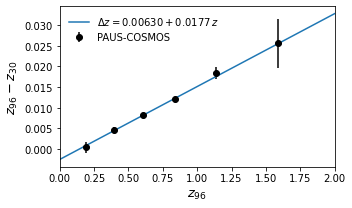

In [8]:
# IN PAPER
f, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
zz = np.linspace(0, 2, 100)
plt.plot(zz, dz0+m*(zz - 0.5), label=f'$\Delta z = {dz0:.5f} + {m:.4f}\, z$')
plt.xlabel('$z_{96}$', fontsize=13)
plt.ylabel('$z_{96}-z_{30}$', fontsize=13)
plt.xlim([0, 2])
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('/mnt/zfsusers/gravityls_3/codes/DESxHSC/paper_plots/zdiff_PAU.pdf')
plt.show()
plt.close()

Compute bootstrap errors and covariance

In [9]:
ngal = len(c)
dz0s, ms = [], []
for i in range(250):
    if i % 10 == 0:
        print(i)
    ids = np.random.choice(range(ngal), size=ngal)
    _, _, _, _, dz0_h, m_h = get_dz(c[ids], zbins)
    dz0s.append(dz0_h)
    ms.append(m_h)
dz0s = np.array(dz0s)
ms = np.array(ms)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [10]:
cv = np.cov(np.array([dz0s, ms]))
print('sigma(A), sigma(B) = ', np.sqrt(np.diag(cv)))
print('r_mat = ',cv/np.sqrt(np.diag(cv)[:, None]*np.diag(cv)[None, :]))

sigma(A), sigma(B) =  [0.0004952  0.00365001]
r_mat =  [[ 1.        -0.3188485]
 [-0.3188485  1.       ]]


(0.0, 2.0)

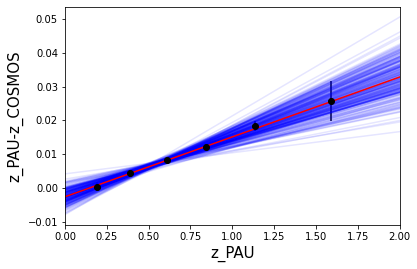

In [11]:
plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
zz = np.linspace(0, 2, 100)
for dz0_h, m_h in zip(dz0s, ms):
    plt.plot(zz, dz0_h+m_h*(zz-0.5), 'b-', alpha=0.1)
plt.plot(zz, dz0+m*(zz-0.5), 'r-', label='%lf + %lf * z' % (dz0, m))
plt.xlabel('z_PAU', fontsize=15)
plt.ylabel('z_PAU-z_COSMOS', fontsize=15)
plt.xlim([0, 2])

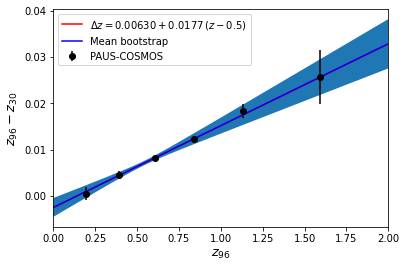

In [12]:
zz = np.linspace(0, 2, 50)
dz = []
sdz = []
mdz = []
for izz in zz: 
    dz.append(dz0s + ms*(izz - 0.5))
    mdz.append(np.mean(dz[-1]))
    sdz.append(np.std(dz[-1]))
dz = np.array(dz)
sdz = np.array(sdz)
mdz = np.array(mdz)

plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
plt.plot(zz, dz0+m*(zz - 0.5), 'r-', label=f'$\Delta z = {dz0:.5f} + {m:.4f}\, (z-0.5)$')
# plt.plot(zz, dz0+m*(zz), 'r-', label='Best fit')
plt.plot(zz, mdz, c='b', label='Mean bootstrap')
# plt.errorbar(zz, mdz, yerr=sdz, fmt='.', color='b')
plt.fill_between(zz, mdz-sdz, mdz+sdz)
plt.legend()

plt.xlabel('$z_{96}$', fontsize=13)
plt.ylabel('$z_{96}-z_{30}$', fontsize=13)
plt.xlim([0, 2])

plt.show()

Removed no burn in


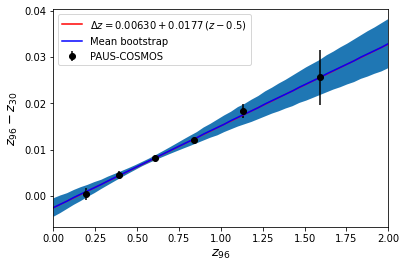

In [13]:
pnames = [f'dz_{izz}' for izz in zz]
samples = MCSamples(samples=dz.T, names=pnames)

pinfo = np.zeros((len(pnames), 3))
for i, pn in enumerate(pnames):
    pinfo[i] = get_par_info(samples, pn, 1)
    
plt.errorbar(zms, dzs, yerr=szs, fmt='ko', label='PAUS-COSMOS')
plt.plot(zz, dz0+m*(zz-0.5), 'r-', label=f'$\Delta z = {dz0:.5f} + {m:.4f}\, (z - 0.5)$')
# plt.plot(zz, dz0+m*(zz), 'r-', label='Best fit')
plt.plot(zz, pinfo[:, 0], c='b', label='Mean bootstrap')
# plt.errorbar(zz, pinfo[:, 0], yerr=pinfo[:, 1:].T, fmt='.', color='b')
plt.fill_between(zz, pinfo[:, 0]-pinfo[:, 1], pinfo[:, 0]+pinfo[:, 2])
plt.legend()

plt.xlabel('$z_{96}$', fontsize=13)
plt.ylabel('$z_{96}-z_{30}$', fontsize=13)
plt.xlim([0, 2])

plt.show()